In [3]:
import gunpowder as gp
import numpy as np
import zarr
import matplotlib.pyplot as plt
import math

In [7]:
def imshowPair(img1, img2):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    plt.axis('off')


def imshow(*args, n=5, figurezize=(10, 4)):
    num_args = len(args)
    plt.figure(figsize=figurezize)
    for row_idx, image_set in enumerate(args): 
        image_set = np.array(image_set)
        n = min(n, image_set.shape[0])
        for col_idx in range(n):
            ax = plt.subplot(num_args, n, row_idx * n + col_idx + 1)
            plt.imshow(image_set[col_idx])
            plt.axis('off')
    plt.show()


In [5]:
pathZarr = "/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/dataC.zarr"
data = zarr.open(pathZarr, mode='r')
data.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='gt', nodes=(Node(disabled=True, ico…

In [8]:
class OffsectNegative(gp.BatchFilter):
  def __init__(self, array):
    self.array = array

  def process(self, batch, request):

    data = batch[self.array].data
    batch[self.array].data = (data - np.min(data)).astype(np.uint16)

class CorrectStride(gp.BatchFilter):
  def __init__(self, array):
    self.array = array

  def process(self, batch, request):

    data = batch[self.array].data
    batch[self.array].data =data.copy()

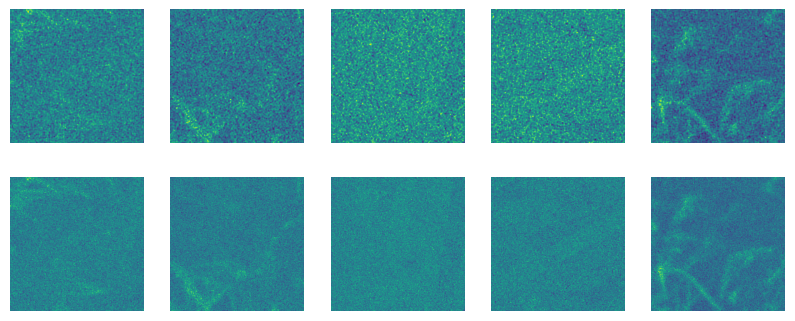

In [12]:
# Basic Argumentations

raw = gp.ArrayKey('RAW')
gt = gp.ArrayKey('GT')

source1 = gp.ZarrSource(
    pathZarr,
    {
      raw: 'tr/tr000',
      gt: 'gt/gt000'
    },
    {
      raw: gp.ArraySpec(interpolatable=True),
      gt: gp.ArraySpec(interpolatable=False)
    })

request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0), (256, 256))
request[gt] = gp.Roi((0, 0), (256, 256))

pipeline = (
    source
    + gp.RandomLocation()
    + OffsectNegative(raw)
    + gp.Normalize(raw)
    + OffsectNegative(gt)
    + gp.Normalize(gt)
    + gp.SimpleAugment()
    + gp.ElasticAugment([100,100], [0.5,0.5], [0,math.pi/2.0])
    + gp.Stack(10)
)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(batch[raw].data, batch[gt].data, n=5)


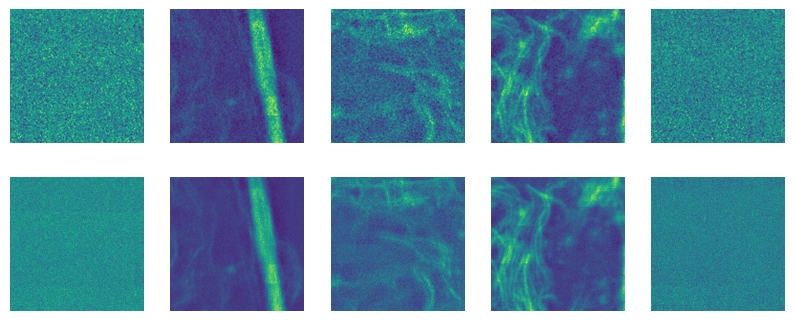

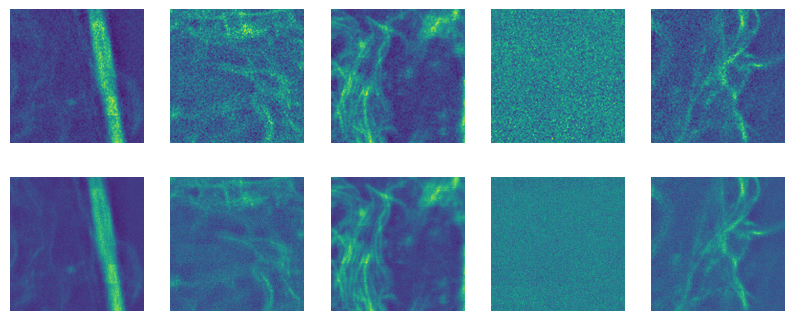

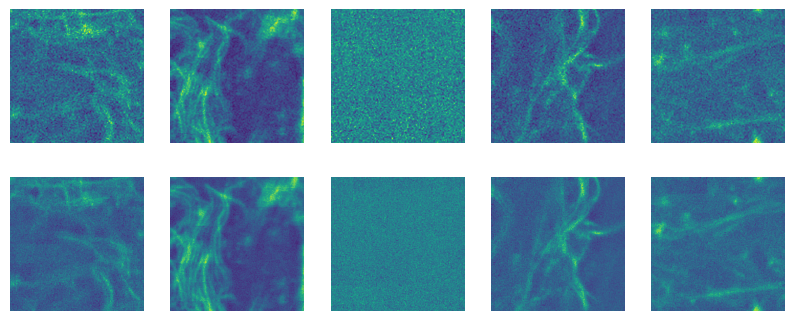

In [10]:
for ii in range(40):
    if ii == 0:
        source2 = gp.ZarrSource(
        pathZarr,
        {
        raw: 'tr/tr000',
        gt: 'gt/gt000'
        },
        {
        raw: gp.ArraySpec(interpolatable=True),
        gt: gp.ArraySpec(interpolatable=False)
        })
    else:
        source2 += gp.ZarrSource(
        pathZarr,
        {
            raw: f'tr/tr{ii:03d}',
            gt: f'gt/gt{ii:03d}'
        },
        {
            raw: gp.ArraySpec(interpolatable=True),
            gt: gp.ArraySpec(interpolatable=False)
        })
    

pipeline = (
    source
    + gp.RandomProvider()
    + gp.RandomLocation()
    + gp.Normalize(raw, factor=1.0/65535)
    + OffsectNegative(gt)
    + gp.Normalize(gt, factor=1.0/65535)
    + gp.SimpleAugment()
    + gp.Stack(5)
)
    
request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0), (256, 256))
request[gt] = gp.Roi((0, 0), (256, 256))


with gp.build(pipeline):
    for i in range(3):
        batch = pipeline.request_batch(request)
        imshow(batch[raw].data, batch[gt].data)
 

In [250]:
import torch
import torch.nn as nn
import sys
sys.path.insert(0, '..')
from Models import UNet

# Model Parameters
in_channels=1
out_channels=1
depth=4
final_activation=None

# Define Model
model = UNet(
    in_channels=in_channels, 
    out_channels=out_channels, 
    depth=depth, 
    final_activation=final_activation
    )

# Training Parameters
optimizer = torch.optim.Adam(model.parameters(),lr=0.00001)
loss_function = nn.MSELoss()

metric = None
n_epochs = 10


prediction = gp.ArrayKey('PREDICTION')

train = gp.torch.Train(
  model=model,
  loss=loss_function,
  optimizer=optimizer,
  inputs = {
    'input': raw
  },
  loss_inputs = {
    0: prediction,
    1: gt
  },
  outputs = {
    0: prediction
  })


In [277]:
pipeline = (
    gp.ZarrSource(
        pathZarr,
        {
        raw: 'tr/tr000',
        gt: 'gt/gt000'
        },
        {
        raw: gp.ArraySpec(interpolatable=True),
        gt: gp.ArraySpec(interpolatable=False)
        })
    + gp.RandomLocation()
    + OffsectNegative(raw)
    + gp.Normalize(raw)
    + OffsectNegative(gt)
    + gp.Normalize(gt)
    + gp.SimpleAugment()
    + CorrectStride(gt)
    + CorrectStride(raw)
    + gp.Unsqueeze([raw, gt], axis=0)
    + train
)

request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0), (512, 512))
request[gt] = gp.Roi((0, 0), (512, 512))
request[prediction] = gp.Roi((0, 0), (512, 512))

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(batch[raw].data, batch[gt].data, batch[prediction].data)


PipelineRequestError: Exception in pipeline:
ZarrSource[/mnt/efs/shared_data/restorators/monalisa_data/Actin_20nmScanStep/dataC.zarr] -> RandomLocation -> OffsectNegative -> Normalize -> OffsectNegative -> Normalize -> SimpleAugment -> CorrectStride -> CorrectStride -> Unsqueeze -> Train
while trying to process request

	RAW: ROI: [0:512, 0:512] (512, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	GT: ROI: [0:512, 0:512] (512, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	PREDICTION: ROI: [0:512, 0:512] (512, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
